# Spatial Analysis of Water Sendimentation

The data we are interested in is each water sedimentation study point with five miles buffer. For each remote sensing file, we make three ways to construct the classification methods, and select the most practical method to construct the land use classification. Because our study sample is very small in terms of most large deep learning model, so the best practible way is to first use unsupervised classificaiton method for each region and then 

The second method is to merge the study samples into a single unit and then classify them using unsupervised classification method. The last method is directly using ESRI pre-trained deep learning model.

In [5]:
# you need to download this package using kernel
# and you need to download and install other kernel packages in arcgis pro management environment
# pip install openeo

In [16]:
# this is the necessary packages for the code
import arcpy
from arcpy.sa import *
import os
import glob
import re
import openeo
import xarray
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely import Point, Polygon
import numpy as np
from datetime import datetime
import rasterio
from rasterio.transform import from_origin
from rasterio.transform import Affine

now change the working directory to the folder that you need to download the data into.

In [17]:
os.chdir(r'E:\umich\644 final project')

## Downloading the Remote Sensing File

here we are reading a sediment examination point retrieved from the michigan river. For this project, we only consider six study points which are in Michigan during November, and for larger projects the code is still reusable and we can direclty run the codes to reimplement the result

In [18]:
data = pd.read_excel('sediment.xlsx')
data = data.dropna(how='all')
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

breifly summarize the columns that we have

In [19]:
data.columns

Index(['ActivityStartDate', 'ActivityConductingOrganizationText',
       'MonitoringLocationIdentifier', 'latitude', 'longitude',
       'HydrologicEvent', 'CharacteristicName', 'ResultMeasureValue',
       'ResultMeasure/MeasureUnitCode', 'ResultStatusIdentifier', 'geometry'],
      dtype='object')

this function create a polygon around the point seriving as 5 miles buffer

In [20]:
def create_square_polygon(point, distance_miles):
    """_summary_
    Create a square polygon around the point with the specified distance in miles.
    
    Args:
        point: A Shapely Point object with longitude and latitude.
        distance_miles: Distance from the point to the edges of the square in miles.
    
    Returns a tuple with (min_lon, max_lon, min_lat, max_lat) representing the square.
    
    """
    miles_per_degree_lat = 69.0
    distance_degrees_lat = distance_miles / miles_per_degree_lat
    
    avg_lat = point.y
    miles_per_degree_lon = 69.172 * np.cos(np.radians(avg_lat))
    distance_degrees_lon = distance_miles / miles_per_degree_lon
    
    # Calculate square boundaries
    min_lon = point.x - distance_degrees_lon
    max_lon = point.x + distance_degrees_lon
    min_lat = point.y - distance_degrees_lat
    max_lat = point.y + distance_degrees_lat
    
    # Return the square as a tuple of its boundary coordinates
    return (min_lon, max_lon, min_lat, max_lat)


squares = data['geometry'].apply(lambda x: create_square_polygon(x, 5))
data['square_boundaries'] = squares

summarize the sample boundary

In [21]:
data['square_boundaries'][0]

(-84.5876081607477, -84.39395543925228, 41.63703103188406, 41.78195856811595)

now we need to convert the time to make it be appropriate to export to the extracted name. Note that the saved file is like "starting date" + "monitoring point"

In [22]:
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])

# Now convert to 'YYYY-MM-DD' format
data['ActivityStartDate'] = data['ActivityStartDate'].dt.strftime('%Y-%m-%d')

In [23]:
data['name'] = data['ActivityStartDate'] + '_' + data['MonitoringLocationIdentifier']
data['name'] = data['name'].str.replace('-', '_', regex=False)

now we connect to the open website to get the data downloaded. The data we are interesting is the sentinel-2 data L2A data. It consists of 12 bands and more other supportive bands. So we can directly download them

In [10]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

Note the NullAuth in the representation of the connection, which indicates that we are not logged in yet.

The canonical way to log in is using the authenticate_oidc() method. This might, depending on your situation, trigger an authentication procedure. Follow the instructions, if any.

In [11]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Note that the connection is now authenticated now through OidcBearerAuth.

With our authenticated connection, we can now start loading a data collection data to build a DataCube, filtered according to specific spatio-temporal constraints:

now give a test for the first object

In [24]:
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])
data['StartOfMonth'] = data['ActivityStartDate'].dt.to_period('M').dt.start_time
data['EndOfMonth'] = data['ActivityStartDate'].dt.to_period('M').dt.end_time
data['EndOfMonth'] = data['EndOfMonth'].dt.date

take a look at the first sample

In [25]:
i = 0
data['StartOfMonth'][i].strftime('%Y-%m-%d')

'2020-11-01'

the bright clouds ruin the composite image.

## Cloud masking

First we build a binary cloud mask from the SCL values 3 (cloud shadows), 8 (cloud medium probability) and 9 (cloud high probability):

specify the bands that we are going to download

In [27]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

this is the downloading function and

In [ ]:

for i in range(len(data)):
    start_date_iso = data['StartOfMonth'][i].strftime('%Y-%m-%d')
    end_date_iso = data['EndOfMonth'][i].strftime('%Y-%m-%d')

    # First, download the SCL band separately
    s2_cube_scl = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=(start_date_iso, end_date_iso),
        spatial_extent={
            "west": data['square_boundaries'][i][0],
            "south": data['square_boundaries'][i][2],
            "east": data['square_boundaries'][i][1],
            "north": data['square_boundaries'][i][3],
            "crs": "EPSG:4326",
        },
        bands=['SCL'],
        max_cloud_cover=50,
    )
    scl_band = s2_cube_scl.band("SCL")
    cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)
    cloud_mask = cloud_mask.resample_cube_spatial(s2_cube_scl)
    
    for j in bands:
        # Now load each spectral band and apply the SCL mask
        s2_cube = connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=(start_date_iso, end_date_iso),
            spatial_extent={
                "west": data['square_boundaries'][i][0],
                "south": data['square_boundaries'][i][2],
                "east": data['square_boundaries'][i][1],
                "north": data['square_boundaries'][i][3],
                "crs": "EPSG:4326",
            },
            bands=[j],
            max_cloud_cover=50,
        )
        # Apply the previously downloaded cloud mask
        cube_masked = s2_cube.mask(cloud_mask)
        
        day_of_month = data['ActivityStartDate'][i].day
        if day_of_month > 20:
            result_cube = cube_masked.max_time()
        elif day_of_month > 10:
            result_cube = cube_masked.median_time()
        else:
            result_cube = cube_masked.min_time()
        
        result_cube.download("{}_{}.nc".format(data['name'][i], j))

print("Downloads complete.")


In [ ]:
ds = xarray.load_dataset("{}_{}.nc".format(data['name'][0], bands[0]))
# Convert xarray DataSet to a (bands, t, x, y) DataArray
# des = ds[bands[0]].to_array(dim="bands")

In [ ]:
ds[bands[0]].plot.imshow(vmin=0, vmax=2000)

In [ ]:
if os.path.exists("../outputs"):
    pass
else:
    os.makedirs("../outputs")

In [ ]:
name_list = []
entries = os.listdir()
for file in entries:
    if file.endswith(".nc"):
        name_list.append(file)

output_list = [file.replace('.nc', '.tif') for file in name_list]
for i in range(0, len(output_list)):
    output_list[i] = os.path.join("../outputs", output_list[i])

now we convert the files to tiff format so that we can use it in our further analysis

In [ ]:
# Assuming name_list and output_list are defined somewhere above
for i in range(len(name_list)):
    # Load the dataset
    data = xarray.load_dataset(name_list[i])
    pattern = re.compile(r"_(B\d+[A-Z]?)")
    band = pattern.search(name_list[i]).group(1)
    # Print available data variables
    # print(f"Available variables in dataset {i}: {list(data.data_vars)}")
    band_name = band  # Assuming 'bands' has the intended band names
    if band_name not in data.data_vars:
        print(f"Band '{band_name}' not found in dataset {i}.")
        continue  # Skip this iteration if the band is not found

    # Accessing the single band data
    des = data[band_name].values

    # Accessing the coordinates
    x = data.x.values
    y = data.y.values

    # Calculate pixel sizes
    pixel_size_x = x[1] - x[0]
    pixel_size_y = y[0] - y[1]

    # Define the transform
    transform = Affine(pixel_size_x, 0, x[0],
                       0, -pixel_size_y, y[0])

    # Open the output raster file for writing
    with rasterio.open(
        output_list[i], 
        'w',
        driver='GTiff',
        height=des.shape[0],  # Height from the shape of the 2D array
        width=des.shape[1],   # Width from the shape of the 2D array
        count=1,  # Only one band
        dtype=des.dtype,
        crs='EPSG:4326',
        transform=transform
    ) as dst:
        # Write the single band to the files
        dst.write(des, 1)


we can also build Pyramids information on these tiff files.

In [32]:
name_list = []
for file in os.listdir("../outputs"):
    if file.endswith(".tif"):
        name_list.append(file)

In [33]:
os.chdir('../outputs')

In [34]:
for i in range(0, len(name_list)):
    raster_path = name_list[i]
    # Optional parameters for building pyramids
    pyramid_levels = ""  # Specify the number of levels or leave as an empty string
    resampling_technique = "NEAREST"  # Options: NEAREST, BILINEAR, CUBIC, MAJORITY
    compression_type = "DEFAULT"  # Compression type
    compression_quality = "75"  # Compression quality (for applicable formats)
    skip_existing = "SKIP_EXISTING"  # Whether to skip building pyramids for rasters that already have them

    # Build or rebuild pyramids
    arcpy.BuildPyramids_management(raster_path, \
                               pyramid_levels, \
                               "NONE",  # SKIP_FIRST is not applicable here; use "NONE" for no skipping
                               resampling_technique, 
                               compression_type, 
                               compression_quality, 
                               skip_existing)

print("Pyramids built successfully.")

Pyramids built successfully.


list all the sample data that we have been downloaded from the openeo website and we now need to combine selected bandswidth to use in the future work

In [64]:
def extract_matched_parts(filenames, pattern):
    extracted_parts = []
    for name in filenames:
        match = re.match(pattern, name)
        if match:
            # Append the captured part of the filename (everything before _Bxx.tif)
            extracted_parts.append(match.group(1))
    return extracted_parts


pattern = r'(.+)_B.*\.tif$'
matched_filenames = extract_matched_parts(name_list, pattern)
result = set(matched_filenames)
result = list(result)
# result = [x + ".tif" for x in result]

In [65]:
bands = ['B02', 'B03', 'B04', 'B08']
nc_files = []
for i in range(0, len(result)):
    nc_files.append([f"{result[i]}_{band}.tif" for band in bands])

In [66]:
# Loop through each set of bands
for file_group in nc_files:
    # Extract the base name without the band part for use as the output filename
    base_name = file_group[0].split("_B")[0]
    output_path = f"../644 final project/{base_name}_composite.tif"
    
    # Combine the bands into a single raster
    arcpy.CompositeBands_management(file_group, output_path)
    print(f"Composite image created: {output_path}")

Composite image created: ../644 final project/2020_11_12_USGS_04177080_composite.tif
Composite image created: ../644 final project/2020_11_23_USGS_04119400_composite.tif
Composite image created: ../644 final project/2020_11_09_USGS_04157005_composite.tif
Composite image created: ../644 final project/2020_11_17_USGS_04040000_composite.tif
Composite image created: ../644 final project/2020_11_10_USGS_04142000_composite.tif
Composite image created: ../644 final project/2020_11_19_USGS_04059500_composite.tif


In [67]:
os.chdir('../644 final project')

In [68]:
name_list = []
for file in os.listdir():
    if file.endswith(".tif"):
        name_list.append(file)

In [70]:
with rasterio.open(name_list[0]) as src:
    print(f"Number of bands: {src.count}")
    # Optionally, print each band's data type
    for i in range(src.count):
        print(f"Band {i+1} data type: {src.dtypes[i]}")

Number of bands: 4
Band 1 data type: float32
Band 2 data type: float32
Band 3 data type: float32
Band 4 data type: float32


now we list all the files and check the maximum and minimum value of each result

In [4]:
raster = arcpy.Raster(name_list[0])

# Get the count of bands in the raster
band_count = raster.bandCount

arcpy.management.CalculateStatistics(name_list[0])

# Create a Raster object
raster = arcpy.Raster(name_list[0])

# Print the number of bands
print(f"Total bands: {raster.bandCount}")

# Loop through each band to get min and max values
for i in range(1, raster.bandCount + 1):
    # For each band, get the minimum value
    min_val = arcpy.GetRasterProperties_management(name_list[0], "MINIMUM", f"Band_{i}")
    # For each band, get the maximum value
    max_val = arcpy.GetRasterProperties_management(name_list[0], "MAXIMUM", f"Band_{i}")
    
    # Print the min and max values for each band
    print(f"Band {i}:")
    print(f" Minimum value: {min_val.getOutput(0)}")
    print(f" Maximum value: {max_val.getOutput(0)}")

Total bands: 4
Band 1:
 Minimum value: -590
 Maximum value: 6620
Band 2:
 Minimum value: -188
 Maximum value: 6764
Band 3:
 Minimum value: -596
 Maximum value: 6640
Band 4:
 Minimum value: -33
 Maximum value: 6624


now we check the spatial reference and check out the pixel type for each file

In [11]:
# we first need some verification

for raster in name_list:
    if arcpy.Exists(raster):
        # Get raster description
        desc = arcpy.Describe(raster)
        # Spatial reference
        spatial_ref = desc.spatialReference.name if desc.spatialReference else "None"
        print(f"Spatial Reference for {raster}: {spatial_ref}")
        
        # Pixel type
        pixel_type = arcpy.GetRasterProperties_management(raster, "VALUETYPE").getOutput(0)
        print(f"Pixel Type for {raster}: {pixel_type}")
        
        # Number of bands
        band_count = desc.bandCount
        print(f"Number of Bands in {raster}: {band_count}")


Spatial Reference for 2020_11_09_USGS_04157005.tif: GCS_WGS_1984
Pixel Type for 2020_11_09_USGS_04157005.tif: 9
Number of Bands in 2020_11_09_USGS_04157005.tif: 4
Spatial Reference for 2020_11_10_USGS_04142000.tif: GCS_WGS_1984
Pixel Type for 2020_11_10_USGS_04142000.tif: 9
Number of Bands in 2020_11_10_USGS_04142000.tif: 4
Spatial Reference for 2020_11_12_USGS_04177080.tif: GCS_WGS_1984
Pixel Type for 2020_11_12_USGS_04177080.tif: 9
Number of Bands in 2020_11_12_USGS_04177080.tif: 4
Spatial Reference for 2020_11_17_USGS_04040000.tif: GCS_WGS_1984
Pixel Type for 2020_11_17_USGS_04040000.tif: 9
Number of Bands in 2020_11_17_USGS_04040000.tif: 4
Spatial Reference for 2020_11_19_USGS_04059500.tif: GCS_WGS_1984
Pixel Type for 2020_11_19_USGS_04059500.tif: 9
Number of Bands in 2020_11_19_USGS_04059500.tif: 4
Spatial Reference for 2020_11_23_USGS_04119400.tif: GCS_WGS_1984
Pixel Type for 2020_11_23_USGS_04119400.tif: 9
Number of Bands in 2020_11_23_USGS_04119400.tif: 4


after we have classified the data and because our different types of results have different range so we need to use map algebra to transform the classification results to a single comparable level

here we consider the minimal cell size of each file

In [ ]:
# Initialize a list to store cell sizes
cell_sizes = []

# Loop through each raster to get its cell size
for raster_path in name_list:
    raster = arcpy.Raster(raster_path)
    # Get the cell size properties
    cell_size_x = raster.meanCellWidth
    cell_size_y = raster.meanCellHeight
    
    # Optionally, average the cell size if it's not square, but usually, they should be the same
    mean_cell_size = (cell_size_x + cell_size_y) / 2
    cell_sizes.append(mean_cell_size)

# Use the smallest cell size for the mosaic
min_cell_size = min(cell_sizes)
print(f"Minimum cell size to use: {min_cell_size}")

this is the code for merging the multiple small area study sample to get a whole picture of the whole area. This method should be taken out of control if the study area is from one area to another area that is far away.

In [ ]:
output_tiff = f"merged2.tif"
    
output_pixel_type = "32_BIT_FLOAT"  # Choose based on your data, e.g., 16_BIT_UNSIGNED, 32_BIT_FLOAT
number_of_bands = 4
cell_size = 10  # Specify or leave as an empty string to use the source
mosaic_method = "LAST"  # LAST, FIRST, BLEND, MEAN, MINIMUM, MAXIMUM
spatial_ref = arcpy.SpatialReference(4326)
# Execute MosaicToNewRaster
arcpy.management.MosaicToNewRaster(name_list, arcpy.env.workspace, output_tiff, spatial_ref, output_pixel_type, cell_size, number_of_bands,\
                                           "LAST","Reject")
print(f"The {number_of_bands} files have been combined into a multi-band TIFF file.")

plot the area

In [ ]:
original_graph = output_tiff
data = Raster(output_tiff)
data

## Method 1

Classification using unsupervised classification method and then automatically generate labels

In [80]:
input_raster_problem = arcpy.Raster(name_list[5])

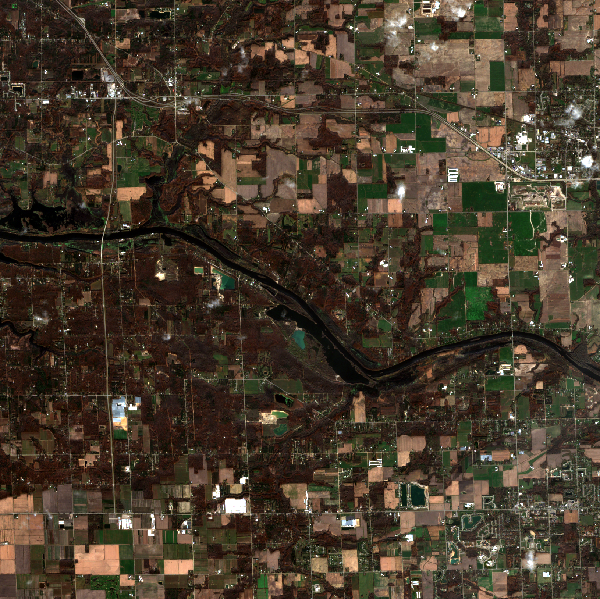

In [81]:
input_raster_problem

In [56]:
input_raster = arcpy.Raster(name_list[4])

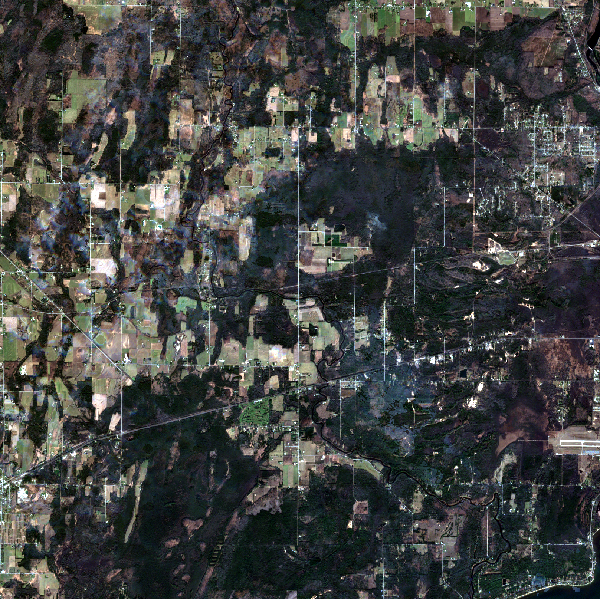

In [58]:
input_raster

now we consider multiple areas and in each area we classify the tiff result to multiple classes and then consider for each area the result.

In [61]:
arcpy.env.workspace = r"E:\umich\Urban-Effect-Of-Water-Sediment"
if not os.path.exists("../result"):
    os.makedirs("../result")
for i in range(0, len(name_list)):
    input_raster_file = name_list[i]  # Your 4-band input TIFF file
    # Set the number of classes for the classification
    num_classes = 8

    # Set the minimum number of cells in each class (optional)
    minimum_class_size = 2

    # Set the sampling interval (optional)
    sample_interval = 10

    # Define the output signature file path (optional)
    output_signature_file = "classification_signatures.gsg"

    # Perform the unsupervised classification
    out_unsupervised_classification = IsoClusterUnsupervisedClassification(
    input_raster_file, 
    num_classes, 
    minimum_class_size, 
    sample_interval)

    classified_raster = "../result/{}.tif".format(name_list[i].replace('.tif', '_classified'))
    out_unsupervised_classification.save(classified_raster)

    # output_shapefile = "../result/{}.shp".format(name_list[i].replace('.tif', '_classified'))
    # arcpy.RasterToPolygon_conversion(classified_raster, output_shapefile, "NO_SIMPLIFY", "VALUE")

In [ ]:
arcpy.env.workspace = r"C:\Users\zxuyuan\Downloads\644 codes working"
input_raster_file = "merged2.tif"  # Your 4-band input TIFF file
# Set the number of classes for the classification
num_classes = 20

# Set the minimum number of cells in each class (optional)
minimum_class_size = 2

# Set the sampling interval (optional)
sample_interval = 5

# Define the output signature file path (optional)
output_signature_file = "classification_signatures.gsg"

# Perform the unsupervised classification
out_unsupervised_classification = IsoClusterUnsupervisedClassification(
    input_raster_file, 
    num_classes, 
    minimum_class_size, 
    sample_interval)

from the figure we can see that the automatically generated gridID equals one is the water shape and we can extract it and we can correspondingly make a map with the ID and the land cover type

1. Water - 1
2. Urban
3. Algriculture Area - 8
4. Forest - 2
6. Grassland
7. Bare land
8. Snow and Ice - 7
9. Wetlands

In [5]:
import rasterio
import numpy as np

# Replace 'path_to_your_tiff_file.tif' with the path to your classified TIFF file
with rasterio.open(r'E:\umich\644 project\checking1\classified_raster.tif') as src:
    # Read the first band (assuming single-band data for classification)
    band1 = src.read(1)
    
    # Find the unique values (classes) in the band
    unique_classes = np.unique(band1)
    
    # Count the number of unique values
    number_of_classes = len(unique_classes)
    
    print(f'The number of classes in the TIFF file is: {number_of_classes}')

The number of classes in the TIFF file is: 6


In [6]:
import rasterio
import numpy as np

# Replace 'path_to_your_tiff_file.tif' with the path to your classified TIFF file
with rasterio.open(r'E:\umich\644 project\checking2\classified_raster.tif') as src:
    # Read the first band (assuming single-band data for classification)
    band1 = src.read(1)
    
    # Find the unique values (classes) in the band
    unique_classes = np.unique(band1)
    
    # Count the number of unique values
    number_of_classes = len(unique_classes)
    
    print(f'The number of classes in the TIFF file is: {number_of_classes}')

The number of classes in the TIFF file is: 6


In [9]:
import rasterio
import numpy as np

# Replace 'path_to_your_tiff_file.tif' with the path to your classified TIFF file
with rasterio.open(r'E:\umich\result\2020_11_10_USGS_04142000_classified.tif') as src:
    # Read the first band (assuming single-band data for classification)
    band1 = src.read(1)
    
    # Find the unique values (classes) in the band
    unique_classes = np.unique(band1)
    
    # Count the number of unique values
    number_of_classes = len(unique_classes)
    
    print(f'The number of classes in the TIFF file is: {number_of_classes}')

The number of classes in the TIFF file is: 8


## exporting tiff with different bands to multiple files

## Detecting Water

NDWI utilizes the green and NIR bands to enhance presence of water bodies while supressing other features

$$
NDWI = \frac{(Green - NIR)}{(Green + NIR)}
$$

For Sentinel-2, you can use Band 3 (Green, 560 nm) and Band 8 (NIR, 842 nm).

We can also use the modified nomalized difference water index (MNDWI)

The Modified NDWI (MNDWI) uses Green and SWIR bands to further suppress built-up land features and vegetation, improving water extraction accuracy.

$$
MNDWI = \frac{(Green - SWIR)}{(Green + SWIR)}
$$

We now work on the NDWI using python

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

def calculate_ndwi(green_path, nir_path):
    with rasterio.open(green_path) as green_src, rasterio.open(nir_path) as nir_src:
        # Ensure both rasters have the same shape
        green = green_src.read(1, out_shape=(green_src.height, green_src.width), resampling=Resampling.bilinear)
        nir = nir_src.read(1, out_shape=(nir_src.height, nir_src.width), resampling=Resampling.bilinear)
        
        # Calculate NDWI
        ndwi = (green.astype(float) - nir.astype(float)) / (green + nir + 1e-10)  # Added epsilon to avoid division by zero
        
        # Apply a threshold to identify water bodies
        water_mask = ndwi > 0.3  # Threshold value can be adjusted based on the scene
        
        return water_mask

# Example usage
green_band_path = 'path_to_your_green_band.tif'
nir_band_path = 'path_to_your_nir_band.tif'
water_mask = calculate_ndwi(green_band_path, nir_band_path)

# Here, you could save `water_mask` as a new raster or visualize it using matplotlib


We can use NDBI to classify the result. 

The NDBI is widely used for identifying built-up areas. It leverages the fact that urban areas tend to have higher reflectance in the short-wave infrared (SWIR) range compared to the NIR range.

$$
NDBI = \frac{SWIR - NIR}{NIR + SWIR}
$$

For Sentinel-2, Band 8 (NIR, 842 nm) and Band 11 (SWIR, 1610 nm) are typically used.

The Urban Index is another method to enhance urban areas by using the difference between NIR and SWIR bands. Formula is

$$
UI = \frac{NIR - SWIR}{NIR + SWIR}
$$

Sentinel-2 Bands: For Sentinel-2, Band 8 (NIR, 842 nm) and Band 11 (SWIR, 1610 nm) are typically used.



In [ ]:
import rasterio
import numpy as np

def calculate_ndbi(nir_path, swir_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(swir_path) as swir_src:
        nir = nir_src.read(1).astype(float)
        swir = swir_src.read(1).astype(float)

        # Calculate NDBI
        ndbi = (swir - nir) / (swir + nir + 1e-10)  # Adding a small value to avoid division by zero

        return ndbi

# Example usage
nir_band_path = 'path_to_your_nir_band.tif'
swir_band_path = 'path_to_your_swir_band.tif'
ndbi = calculate_ndbi(nir_band_path, swir_band_path)

# Further steps could include applying a threshold to ndbi to classify urban areas
# and saving or visualizing the results.

Normalized Difference Vegetation Index (NDVI)

$$
NDVI = \frac{(NIR - RED)}{(NIR + RED)}
$$

For Sentinel-2, Band 8 (NIR, 842 nm) and Band 4 (Red, 665 nm) are used.

In [ ]:
import rasterio
import numpy as np

def calculate_ndvi(nir_path, red_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(red_path) as red_src:
        nir = nir_src.read(1).astype(float)
        red = red_src.read(1).astype(float)

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red + 1e-10)  # Adding a small value to avoid division by zero

        return ndvi

# Example usage
nir_band_path = 'path_to_your_nir_band.tif'
red_band_path = 'path_to_your_red_band.tif'
ndvi = calculate_ndvi(nir_band_path, red_band_path)

# To detect bare land, look for areas with low NDVI values
# For example, you might classify areas with NDVI < 0.2 as bare land
bare_land_mask = ndvi < 0.2

# Further processing could include saving this mask as a raster, visualizing it, etc.


Because some of the figures have snowy whether in that day, so we also calculate the snow index

Normalized Difference Snow Index (NDSI)

$$
NDSI = \frac{(Green - SWIR)}{(Green = SWIR)}
$$

For Sentinel-2, use Band 3 (Green, 560 nm) and Band 11 (SWIR, 1610 nm) or Band 12 (SWIR, 2190 nm).

In [ ]:
import rasterio
import numpy as np

def calculate_ndsi(green_path, swir_path):
    with rasterio.open(green_path) as green_src, rasterio.open(swir_path) as swir_src:
        green = green_src.read(1).astype(float)
        swir = swir_src.read(1).astype(float)

        # Calculate NDSI
        ndsi = (green - swir) / (green + swir + 1e-10)  # Adding a small value to avoid division by zero

        return ndsi

# Example usage
green_band_path = 'path_to_your_green_band.tif'
swir_band_path = 'path_to_your_swir_band.tif'
ndsi = calculate_ndsi(green_band_path, swir_band_path)

# Identifying snow/ice usually involves thresholding the NDSI; a common threshold is 0.4
snow_ice_mask = ndsi > 0.4

# You can then save or visualize this mask as needed


To get some data on the wet lands in our area we also calculate the NDMI

NDMI is useful for detecting moisture content in vegetation, which can be indicative of wetlands, especially those with dense vegetative cover.

$$
NDMI = \frac{(NIR - SWIR)}{(NIR + SWIR)}
$$

Sentinel-2 Bands: Band 8 (NIR) and Band 11 (SWIR, 1610 nm) or Band 12 (SWIR, 2190 nm).

In [ ]:
import rasterio
import numpy as np

def calculate_ndmi(nir_path, swir_path):
    with rasterio.open(nir_path) as nir_src, rasterio.open(swir_path) as swir_src:
        nir = nir_src.read(1).astype(float)
        swir = swir_src.read(1).astype(float)

        # Calculate NDMI
        ndmi = (nir - swir) / (nir + swir + 1e-10)  # Adding a small value to avoid division by zero

        return ndmi

# Example usage
nir_band_path = 'path_to_your_nir_band.tif'
swir_band_path = 'path_to_your_swir_band.tif'
ndmi = calculate_ndmi(nir_band_path, swir_band_path)

# Areas with higher NDMI values indicate higher moisture content, potentially highlighting wetlands


https://chat.openai.com/share/041fa8e8-63dd-4a98-915f-49d2aea8d430